<a href="https://colab.research.google.com/github/CherylReschUF/NLPDemo/blob/main/essays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To access the data file we will be using, go to

https://drive.google.com/drive/folders/1AcryqnbxyfgsAqM8y-Hvn0LHKuQVZp2S?usp=sharing

You can download the files and then upload them into your colab environment

OR

create a shortcut to them from your own google drive.

To create a shortcut: click on the folder, scroll down to "Organize" then click on "Add Shortcut".  
Go to "All Locations" then click on "Add" next to "My Drive"


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

directory_path = "drive/MyDrive/NLP Demo"

filename = "essays.xlsx"
file_path = os.path.join(directory_path, filename)


Install the packages we need for sentence transformers and text clustering  

NLTK is natural language toolkit, a suite of libraries and algorithms for natural language processing for English written language.

In [4]:
## Text clustering
!pip install sentence_transformers
!pip install umap-learn
import pandas as pd
import umap
import nltk as nltk
import os
nltk.download('punkt')
nltk.download('punkt_tab')







[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

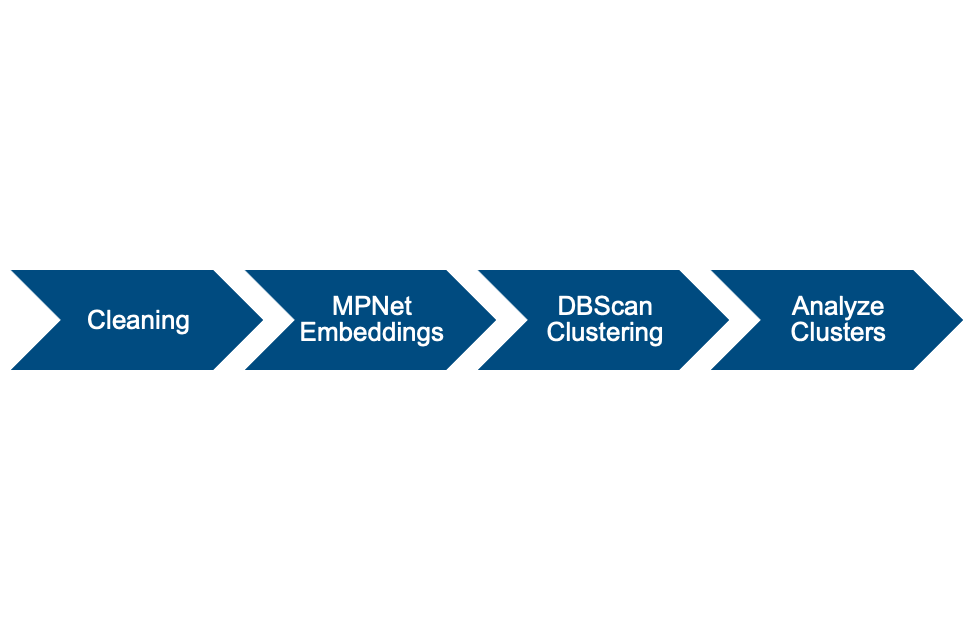

Edit conjunctions, remove carriage returns, remove extra spaces.

Next turn paragraphs into sentences.  Break the essays into individual sentences.



In [ ]:




def cleaning(text):
    if isinstance(text, float):
        text = str(text)
    text = text.replace('\n', ' ')
    text = text.replace("It'\s", "It is")
    text = text.replace("it'\s", "it is")
    text = text.replace("it\'s", "it is")
    text = text.replace("n\'t", " not")
    text = text.replace("\'ll", " will")
    text = text.replace("\'m", " am")
    text = text.replace("\'ve", " have")
    text  = text.replace("I\'m", "I am")
    text = text.replace('.', '. ')
    text = text.replace('   ', ' ')
    text = text.replace('CDA3101', ' ')
    text = text.replace('CDA 3101', ' ')
    text = text.strip()

    return text

dat = pd.read_excel(file_path)
df = pd.DataFrame(dat)
df['Essay'] = df['Essay'].apply(cleaning)
df['sentences']=df['Essay'].apply(nltk.sent_tokenize)
df=df.explode('sentences',ignore_index=True)
df['sentences']=df['sentences'].apply(cleaning)
df=df.drop_duplicates(subset=['sentences'])
corpus=df['sentences']
corpus






[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,sentences
0,has been an entire journey in it of itself.
1,I’m glad to have taken the class with Professo...
2,This class has been a phenomenal learning expe...
3,Probably one of the most important things that...
4,I’ve attained so much knowledge about the inne...
...,...
5728,"As of now, I have not taken another class in t..."
5729,Having a strong understanding in ARM programmi...
5730,"Furthermore, it was consistently reiterated in..."
5731,"Obviously, it is extremely important to have a..."


Create sentence embeddings

A sentence embedding is representation of a sentence as a vector of numbers which encodes meaningful semantic information.  This can include individual words, combinations of words, and the position of the words in a sentence.

We are using Mpnet embeddings.

Song, K., Tan, X., Qin, T., Lu, J., & Liu, T. Y. (2020). Mpnet: Masked and permuted pre-training for language understanding. Advances in Neural Information Processing Systems, 33, 16857-16867.

The basic idea is that a neural network is trained to predict masked works (the m in mpnet)when the words are put in different orders, or permuted (the p in mpnet).

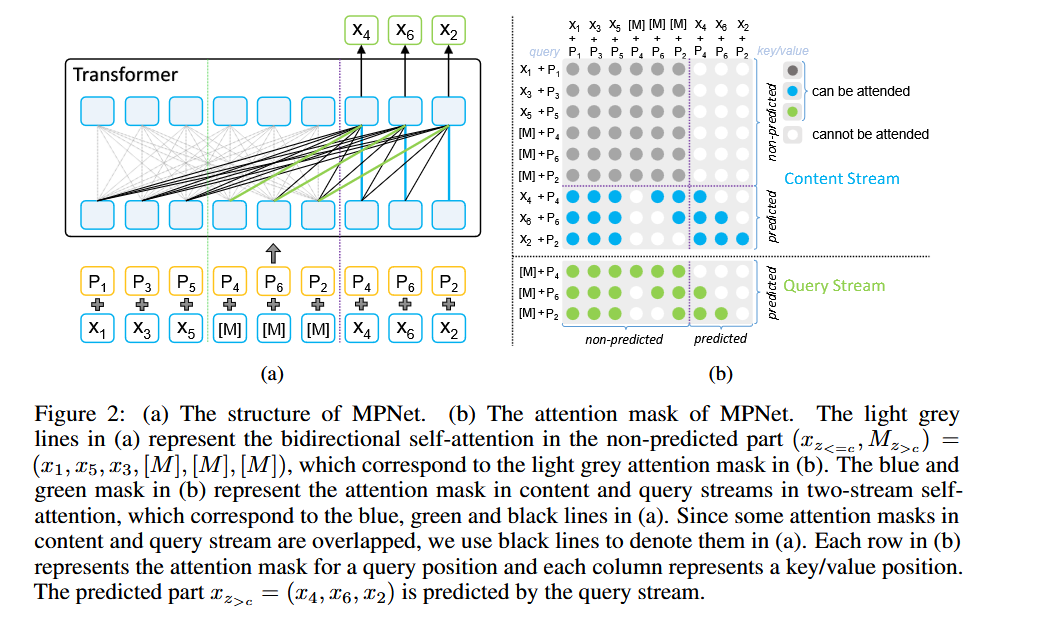

When we ran !pip install sentence_transformers we gave our code access to pretrained models from hugging face -  https://huggingface.co/sentence-transformers

Hugging face has trained multiple models, including mpnet and the very popular BERT on a huge corpus, e.g all of Wikipedia.

We are going to create vectors for our sentences based on the pretrained mpnet model available in hugging face.

In [ ]:

from sentence_transformers import SentenceTransformer
from functools import partial
model_path="all-mpnet-base-v2"
model = SentenceTransformer(model_path)
corpus_embeddings = model.encode(corpus.values)




Set up procedures, set parameters

We now have vectors of 768 numbers describing each sentence.

umap is a dimension reduction algorithm.

hdbscan is a clustering algorithm.

Deng, D. (2020, September). DBSCAN clustering algorithm based on density. In 2020 7th International Forum on Electrical Engineering and Automation (IFEEA) (pp. 949-953). IEEE.

Djouzi, K., & Beghdad-Bey, K. (2019, June). A review of clustering algorithms for big data. In 2019 International Conference on Networking and Advanced Systems (ICNAS) (pp. 1-6). IEEE.

We will use hdbscan to create clusters of similar sentences whose vectors are similar.

We get the clustering algorithm from scikit-learn, a free and open source Python library for machine learning.

In [ ]:
def generate_clusters(message_embeddings,
                      n_neighbors,
                      n_components,
                      min_cluster_size,
                      random_state = None):
    """
    Generate HDBSCAN cluster object after reducing embedding dimensionality with UMAP
    """

    umap_embeddings = (umap.UMAP(n_neighbors=n_neighbors,
                                n_components=n_components,
                                metric='euclidean',
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                               metric='euclidean',
                               cluster_selection_method='eom').fit(umap_embeddings)

    return clusters
def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given cluster supplied from running hdbscan
    """

    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)

    return label_count, cost



def objective(params, embeddings, label_lower, label_upper):
    """
    Objective function for hyperopt to minimize, which incorporates constraints
    on the number of clusters we want to identify
    """

    clusters = generate_clusters(embeddings,
                                 n_neighbors = params['n_neighbors'],
                                 n_components = params['n_components'],
                                 min_cluster_size = params['min_cluster_size'],
                                 random_state = params['random_state'])

    label_count, cost = score_clusters(clusters, prob_threshold = 0.05)

    #penalty on the cost function if outside the desired range of groups
    if (label_count < label_lower) | (label_count > label_upper):
        penalty = 0.20
    else:
        penalty = 0

    loss = cost + penalty

    return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

def bayesian_search(embeddings, space, label_lower, label_upper, max_evals=100):
    """
    Perform bayseian search on hyperopt hyperparameter space to minimize objective function
    """

    trials = Trials()
    fmin_objective = partial(objective, embeddings=embeddings, label_lower=label_lower, label_upper=label_upper)
    best = fmin(fmin_objective,
                space = space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print ("label count: {trials.best_trial['result']['label_count']}")

    best_clusters = generate_clusters(embeddings,
                                      n_neighbors = best_params['n_neighbors'],
                                      n_components = best_params['n_components'],
                                      min_cluster_size = best_params['min_cluster_size'],
                                      random_state = best_params['random_state'])

    return best_params, best_clusters, trials

Run the clustering code

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials
!pip install hdbscan
import hdbscan
import numpy as np




hspace = {
    "n_neighbors":hp.choice('n_neighbors', range(3, 20)),
    "n_components": hp.choice('n_components', range(3, 20)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,20)),
    "random_state": 1
}

label_lower = 10
#was 10
label_upper = 100
max_evals = 30
best_params, best_clusters, trials = bayesian_search(corpus_embeddings,
                                                    space=hspace,
                                                    label_lower=label_lower,
                                                    label_upper=label_upper,
                                                    max_evals=max_evals)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  3%|▎         | 1/30 [00:22<10:49, 22.39s/trial, best loss: 0.5806035234606663]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  7%|▋         | 2/30 [00:42<09:54, 21.24s/trial, best loss: 0.24978196406767836]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 10%|█         | 3/30 [01:01<09:04, 20.17s/trial, best loss: 0.23233908948194662]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 13%|█▎        | 4/30 [01:19<08:24, 19.39s/trial, best loss: 0.23233908948194662]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 17%|█▋        | 5/30 [01:35<07:31, 18.06s/trial, best loss: 0.23233908948194662]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/u

 20%|██        | 6/30 [01:48<06:32, 16.35s/trial, best loss: 0.23233908948194662]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 23%|██▎       | 7/30 [02:01<05:47, 15.11s/trial, best loss: 0.23233908948194662]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 27%|██▋       | 8/30 [02:21<06:05, 16.61s/trial, best loss: 0.23233908948194662]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 30%|███       | 9/30 [02:35<05:36, 16.04s/trial, best loss: 0.23233908948194662]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 33%|███▎      | 10/30 [02:52<05:23, 16.16s/trial, best loss: 0.23233908948194662]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 37%|███▋      | 11/30 [03:10<05:20, 16.86s/trial, best loss: 0.23233908948194662]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 40%|████      | 12/30 [03:21<04:28, 14.91s/trial, best loss: 0.18628990057561487]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/u

 43%|████▎     | 13/30 [03:43<04:51, 17.17s/trial, best loss: 0.18628990057561487]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 47%|████▋     | 14/30 [04:03<04:46, 17.88s/trial, best loss: 0.18628990057561487]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 50%|█████     | 15/30 [04:20<04:26, 17.80s/trial, best loss: 0.18628990057561487]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 53%|█████▎    | 16/30 [04:35<03:56, 16.93s/trial, best loss: 0.18628990057561487]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 57%|█████▋    | 17/30 [04:55<03:53, 17.94s/trial, best loss: 0.18628990057561487]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 60%|██████    | 18/30 [05:05<03:03, 15.33s/trial, best loss: 0.18628990057561487]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 63%|██████▎   | 19/30 [05:16<02:35, 14.09s/trial, best loss: 0.18628990057561487]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/u

 67%|██████▋   | 20/30 [05:33<02:31, 15.14s/trial, best loss: 0.18628990057561487]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 70%|███████   | 21/30 [05:43<02:00, 13.34s/trial, best loss: 0.18628990057561487]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 73%|███████▎  | 22/30 [05:53<01:39, 12.46s/trial, best loss: 0.18628990057561487]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/u

 77%|███████▋  | 23/30 [05:59<01:14, 10.58s/trial, best loss: 0.18628990057561487]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 80%|████████  | 24/30 [06:07<00:58,  9.71s/trial, best loss: 0.18628990057561487]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 83%|████████▎ | 25/30 [06:15<00:46,  9.40s/trial, best loss: 0.18628990057561487]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 87%|████████▋ | 26/30 [06:28<00:41, 10.45s/trial, best loss: 0.18628990057561487]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 90%|█████████ | 27/30 [06:40<00:32, 10.69s/trial, best loss: 0.18628990057561487]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 93%|█████████▎| 28/30 [07:03<00:28, 14.42s/trial, best loss: 0.18628990057561487]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



 97%|█████████▋| 29/30 [07:16<00:14, 14.10s/trial, best loss: 0.18628990057561487]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/sklearn/u

100%|██████████| 30/30 [07:39<00:00, 15.33s/trial, best loss: 0.18628990057561487]
best:
{'min_cluster_size': 18, 'n_components': 6, 'n_neighbors': 6, 'random_state': 1}
label count: {trials.best_trial['result']['label_count']}


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
best_clusters.labels_

array([ 1, 18,  1, ..., 13, -1, 18])

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


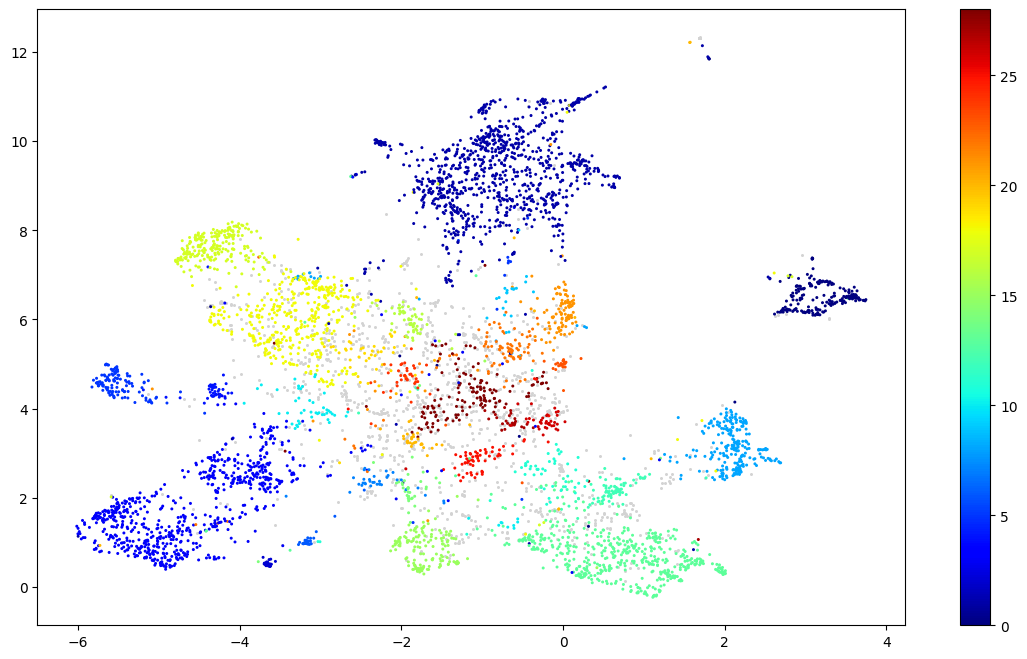

In [ ]:
import matplotlib.pyplot as plt


def plot_clusters(embeddings, clusters, n_neighbors=13, min_dist=0.1):
    """
    Reduce dimensionality of best clusters and plot in 2D

    Arguments:
        embeddings: embeddings to use
        clusteres: HDBSCAN object of clusters
        n_neighbors: float, UMAP hyperparameter n_neighbors
        min_dist: float, UMAP hyperparameter min_dist for effective
                  minimum distance between embedded points

    """
    umap_data = umap.UMAP(n_neighbors=n_neighbors,
                          n_components=2,
                          min_dist = min_dist,
                          #metric='cosine',
                          random_state=42).fit_transform(embeddings)

    point_size = 100.0 / np.sqrt(embeddings.shape[0])

    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = clusters.labels_

    fig, ax = plt.subplots(figsize=(14, 8))
    outliers = result[result.labels == -1]
    clustered = result[result.labels != -1]
    plt.scatter(outliers.x, outliers.y, color = 'lightgrey', s=point_size)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=point_size, cmap='jet')
    plt.colorbar()
    plt.show()
plot_clusters(corpus_embeddings, best_clusters)

In [ ]:
result = pd.DataFrame(corpus)
result['category'] =best_clusters.labels_
result[result.category==9]
with pd.ExcelWriter("10cats.xlsx") as writer:
   result.to_excel(writer)



Sentiment analysis

https://medium.com/@rslavanyageetha/vader-a-comprehensive-guide-to-sentiment-analysis-in-python-c4f1868b0d2e

What is Sentiment Analysis?

Sentiment analysis is a natural language processing (NLP) technique used to determine the sentiment of a piece of text. Sentiment analysis involves analyzing the text to determine whether it is positive, negative, or neutral. Sentiment analysis can be used to analyze social media posts, customer reviews, and other types of user-generated content.

What is Vader?

Vader (Valence Aware Dictionary and sEntiment Reasoner) is a rule-based sentiment analysis tool that is specifically designed for analyzing social media texts. Vader is a pre-trained sentiment analysis model that provides a sentiment score for a given text.

Vader uses a dictionary of words and rules to determine the sentiment of a piece of text. It uses a valence score for each word to determine its positivity or negativity. The valence score ranges from -4 to +4, with -4 being the most negative and +4 being the most positive.

In [ ]:


!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def sent_analyzer(text):
      analyzer = SentimentIntensityAnalyzer()
      return analyzer.polarity_scores(text)


def vader_scores(feedbacktext, category):
      return vader.polarity_scores(feedbacktext).get(category)

vader = SentimentIntensityAnalyzer()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.8 MB/s eta 0:00:00


In [ ]:
corpus


,sentences
0,has been an entire journey in it of itself.
1,I’m glad to have taken the class with Professo...
2,This class has been a phenomenal learning expe...
3,Probably one of the most important things that...
4,I’ve attained so much knowledge about the inne...
...,...
5728,"As of now, I have not taken another class in t..."
5729,Having a strong understanding in ARM programmi...
5730,"Furthermore, it was consistently reiterated in..."
5731,"Obviously, it is extremely important to have a..."


In [ ]:
corpus = pd.DataFrame(corpus)
corpus["Negative_Score"] = corpus.apply(lambda row : vader_scores(corpus["sentences"][row.name], "neg"),axis=1)
corpus["Positive_Score"] = corpus.apply(lambda row : vader_scores(corpus["sentences"][row.name], "pos"),axis=1)
corpus["Neutral_Score"] = corpus.apply(lambda row : vader_scores(corpus["sentences"][row.name], "neu"),axis=1)
corpus["Compound_Score"] = corpus.apply(lambda row : vader_scores(corpus["sentences"][row.name], "compound"),axis=1)
corpus

,sentences,Negative_Score,Positive_Score,Neutral_Score,Compound_Score
0,has been an entire journey in it of itself.,0.000,0.000,1.000,0.0000
1,I’m glad to have taken the class with Professo...,0.000,0.153,0.847,0.7839
2,This class has been a phenomenal learning expe...,0.000,0.000,1.000,0.0000
3,Probably one of the most important things that...,0.000,0.296,0.704,0.8122
4,I’ve attained so much knowledge about the inne...,0.109,0.000,0.891,-0.2960
...,...,...,...,...,...
5728,"As of now, I have not taken another class in t...",0.000,0.000,1.000,0.0000
5729,Having a strong understanding in ARM programmi...,0.000,0.161,0.839,0.8832
5730,"Furthermore, it was consistently reiterated in...",0.000,0.098,0.902,0.3612
5731,"Obviously, it is extremely important to have a...",0.000,0.209,0.791,0.7501


Word Cloud

In [ ]:
 def cleaning(self, string):
        import re
        #string  = string.lower() # step 1. lowercase

        string  = string.replace("can't", 'cannot') # step 3. replace abbreviated forms
        string = string.replace("n't", ' not')
        string  = string.replace("'ll", ' will')
        string  = string.replace("'m", ' am')
        string = string.replace("he's", "he is")
        string = string.replace("it's", 'it is')

        punc = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' # step 2. remove punctuations
        string  = string.strip(punc)


        return re.sub(r"\d+", "<DIGIT>", string) # step 4. replace all the numbers to <DIGIT>

def sent_tokenize(self, string):
        import nltk
        return nltk.sent_tokenize(string)

def tokenize(self, string):
        import nltk
        return nltk.word_tokenize(string)

def stemming(self, tokens):
        import nltk
        stemmer = nltk.stem.PorterStemmer()
        return [stemmer.stem(token) for token in tokens]

def lemmatize(self, tokens):
        import nltk
        lemmatizer = nltk.stem.WordNetLemmatizer()
        return [lemmatizer.lemmatize(token) for token in tokens]

def preprocess(self, string):
         df = self.import_data()
         df.interesting.apply(self.cleaning)
         df.relevant.apply(self.cleaning)
         return df

#normalizer = text_normalize() # call the text_normalize function and name it normalizer

stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()


from nltk.corpus import stopwords

nltk.download('stopwords')
from nltk.tokenize import word_tokenize

def removeStopWords(text):
  text_tokens = word_tokenize(text)
  #text_tokens = [stemmer.stem(token) for token in text_tokens]
  #text_tokens = [lemmatizer.lemmatize(token) for token in text_tokens]

  tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
  return (" ").join(tokens_without_sw)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
words=corpus['sentences'].apply(removeStopWords)
words

AttributeError: 'bool' object has no attribute 'words'

In [ ]:




bigstring=' '.join(words)

bigstring = bigstring.replace('class','')
bigstring = bigstring.replace('course','')
bigstring = bigstring.replace('programming','')
bigstring = bigstring.replace('program','')
bigstring = bigstring.replace('understand','')
bigstring = bigstring.replace('learn','')
bigstring = bigstring.replace('computer','')
bigstring = bigstring.replace('because','')
bigstring = bigstring.replace('topic','')
bigstring = bigstring.replace('science','')
bigstring = bigstring.replace(' I ','')
bigstring = bigstring.replace('like','')
bigstring = bigstring.replace('knowledge','')
bigstring = bigstring.replace('concept','')
bigstring = bigstring.replace('important','')
bigstring = bigstring.replace('different','')
bigstring = bigstring.replace('student','')
bigstring = bigstring.replace(' ed ','')
bigstring = bigstring.replace(' ing','')
bigstring = bigstring.replace('make','')
bigstring = bigstring.replace('interesting','')
bigstring = bigstring.replace('surprising','')
bigstring = bigstring.replace('included','')
bigstring = bigstring.replace(' thing','')
bigstring = bigstring.replace(' s ','')
bigstring = bigstring.replace(' S ','')





bigstring

"entire journey .’ glad  Professor Resch , provided perspective software hardware aspects, experiencedeeply enjoyed . This  phenomenal experience . Probably s’   architecture .’ attained  workings machinesreal .’ interest  hardwarekid .’ bought soldcomponents , , built scratch , minute details’  fully . For ,understood impact higher lower base boost clock processor performance , ,’  outs value represented . Now processors clock speed Hz number cycles processor execute value directly relate number instructions processor handle period .idea L1 , L2 cache represented CPU ,’ completed cache analysis labing impacts cache size , block size performance , variables type cache organization method , replacement policy effect performance machine variables interact . Additionally ,ing structures , caches , laid internally , operate . Notgained breath ,great experience  time .stay focused lectures’ . Usually , lectures boring drawn , mixture Professor Resch ’ personality shorter 50-minute lecture s

In [ ]:
pip install wordcloud

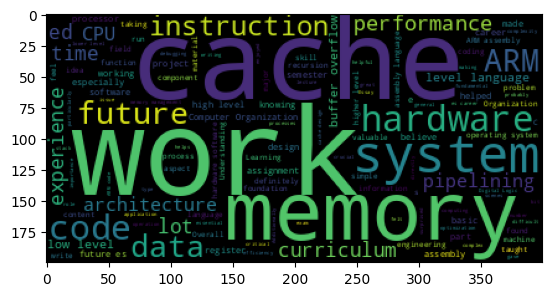

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud().generate(bigstring)
plt.imshow(wc)